### HIGH POWERLINE

Found beam width before the lens: Width x = 1.316 mm, Width y = 1.16 mm in /Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250527/high_powerline/before lens Beam Results.csv
z = 10 mm, Width_x = 1.559 mm, Width_y = 1.388 mm
z = 20 mm, Width_x = 1.239 mm, Width_y = 1.102 mm
z = 30 mm, Width_x = 0.952 mm, Width_y = 0.842 mm
z = 40 mm, Width_x = 0.659 mm, Width_y = 0.574 mm
z = 50 mm, Width_x = 0.330 mm, Width_y = 0.274 mm
z = 60 mm, Width_x = 0.066 mm, Width_y = 0.067 mm
z = 70 mm, Width_x = 0.330 mm, Width_y = 0.326 mm
z = 80 mm, Width_x = 0.625 mm, Width_y = 0.597 mm
z = 90 mm, Width_x = 0.944 mm, Width_y = 0.884 mm
z = 100 mm, Width_x = 1.245 mm, Width_y = 1.154 mm
z = 110 mm, Width_x = 1.509 mm, Width_y = 1.399 mm
z = 120 mm, Width_x = 1.841 mm, Width_y = 1.689 mm
z = 130 mm, Width_x = 2.116 mm, Width_y = 1.945 mm
z = 140 mm, Width_x = 2.438 mm, Width_y = 2.244 mm
z = 150 mm, Width_x = 2.709 mm, Width_y = 2.485 mm
z = 160 mm, Width_x = 3.009 mm, Width_y = 2.756

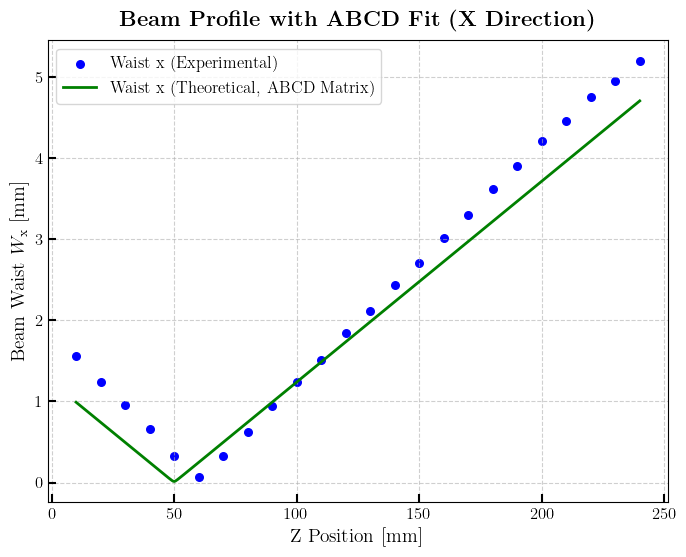

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250527/high_powerline/fig/beam_profile_ABCD_y.png


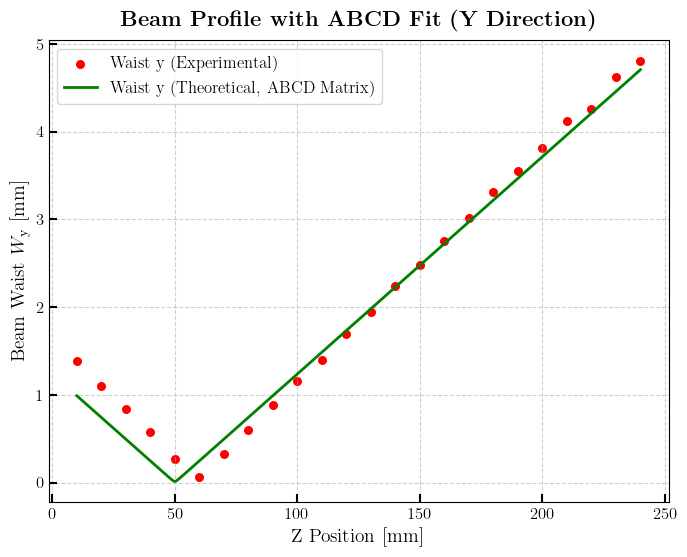

Min waist theo: 0.0139 Max waist theo: 4.7049
Min waist exp x: 0.0659 Min waist exp y: 0.0669


In [8]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data path
data_path = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250527/high_powerline"
file_list = sorted([f for f in glob.glob(os.path.join(data_path, "*mm Beam Results.csv")) 
                    if "before lens" not in os.path.basename(f).lower()])
fig_dir = os.path.join(data_path, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values = []
width_x = []
width_y = []

for file in file_list:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])  
    z_values.append(z)

    with open(file, 'r') as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if "Width x" in line:
            width_x.append(float(line.split()[2]))  
        if "Width y" in line:
            width_y.append(float(line.split()[2]))  

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length = 50  # in mm
wavelength = 1.060e-3  # in mm 

# Beam waist after the lens (at focal length)
W0 = width_x.min()  # Minimum width from data
z_waist = z_values[np.argmin(width_x)]  # Position of the waist
z_R = np.pi * W0**2 / wavelength  # Rayleigh range at the waist in mm

'''
Initial beam parameter before the lens:
Assuming the beam to be collimated but with a finite waist before the lens
Estimate the beam waist before the lens (W0_initial) and its position
The lens focuses the beam at z = 50 mm, use the lens formula for Gaussian beams
'''

# Function to get initial beam waist from "before lens Beam Results.csv"
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Width x' or 'Width y' in {file_path}. File content:")
            print("\n".join(lines))  # Print file content for debugging
            print("Using default W0_initial = 4 mm.")
            return 4.0  # Default value if data not found
        else:
            print(f"Found beam width before the lens: Width x = {width_x_initial} mm, Width y = {width_y_initial} mm in {file_path}")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0

# Read W0_initial from file
before_lens_file = os.path.join(data_path, "before lens Beam Results.csv")
W0_initial = get_initial_beam_waist(before_lens_file)  # Initial beam waist in mm (before the lens)
z_R_initial = np.pi * W0_initial**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0

# Apply the lens transformation at z = 0
A_lens = 1
B_lens = 0
C_lens = -1 / focal_length
D_lens = 1

q1 = (A_lens * q0 + B_lens) / (C_lens * q0 + D_lens)  # Beam parameter just after the lens

# Theoretical z-values for the curve
z_theoretical = np.linspace(min(z_values), max(z_values), 500)
W_theoretical = np.zeros_like(z_theoretical)

# Propagate the beam in free space after the lens
for i, z in enumerate(z_theoretical):
    # ABCD matrix for free space propagation
    A_free = 1
    B_free = z
    C_free = 0
    D_free = 1

    # Transform the beam parameter
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new

    # Beam width from the imaginary part of 1/q_new
    # Ensure the imaginary part is negative (as expected for a Gaussian beam)
    if inv_q_new.imag < 0:
        W_theoretical[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical[i] = np.nan 

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Width_x = {wx:.3f} mm, Width_y = {wy:.3f} mm")
    
# Plot Width x vs. z 
plt.figure(figsize=(8, 6))
plt.scatter(z_values, width_x, color='b', label='Waist x (Experimental)', marker='o', s=30)
plt.plot(z_theoretical, W_theoretical, color='g', linestyle='-', linewidth=2, label='Waist x (Theoretical, ABCD Matrix)')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_x}")
plt.show()

# Plot Width y vs. z 
plt.figure(figsize=(8, 6))
plt.scatter(z_values, width_y, color='r', label='Waist y (Experimental)', marker='o', s=30)
plt.plot(z_theoretical, W_theoretical, color='g', linestyle='-', linewidth=2, label='Waist y (Theoretical, ABCD Matrix)')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_y}")
plt.show()

print(f"Min waist theo: {min(W_theoretical):.4f}",f"Max waist theo: {max(W_theoretical):.4f}")
print(f"Min waist exp x: {min(width_x):.4f}",f"Min waist exp y: {min(width_y):.4f}")




Found beam width before the lens: Width x = 1.316 mm, Width y = 1.16 mm
q3 (after second lens): (-1499.999999997338+113559.9795039735j)
q4 (before third lens at z = 441 mm): (-1358.999999997338+113559.9795039735j)
q5 (after third lens): (-25.399930750941436+0.005680382599758719j)
z = 10 mm, Width_x = 1.559 mm, Width_y = 1.388 mm
z = 20 mm, Width_x = 1.239 mm, Width_y = 1.102 mm
z = 30 mm, Width_x = 0.952 mm, Width_y = 0.842 mm
z = 40 mm, Width_x = 0.659 mm, Width_y = 0.574 mm
z = 50 mm, Width_x = 0.330 mm, Width_y = 0.274 mm
z = 60 mm, Width_x = 0.066 mm, Width_y = 0.067 mm
z = 70 mm, Width_x = 0.330 mm, Width_y = 0.326 mm
z = 80 mm, Width_x = 0.625 mm, Width_y = 0.597 mm
z = 90 mm, Width_x = 0.944 mm, Width_y = 0.884 mm
z = 100 mm, Width_x = 1.245 mm, Width_y = 1.154 mm
z = 110 mm, Width_x = 1.509 mm, Width_y = 1.399 mm
z = 120 mm, Width_x = 1.841 mm, Width_y = 1.689 mm
z = 130 mm, Width_x = 2.116 mm, Width_y = 1.945 mm
z = 140 mm, Width_x = 2.438 mm, Width_y = 2.244 mm
z = 150 mm, Wi

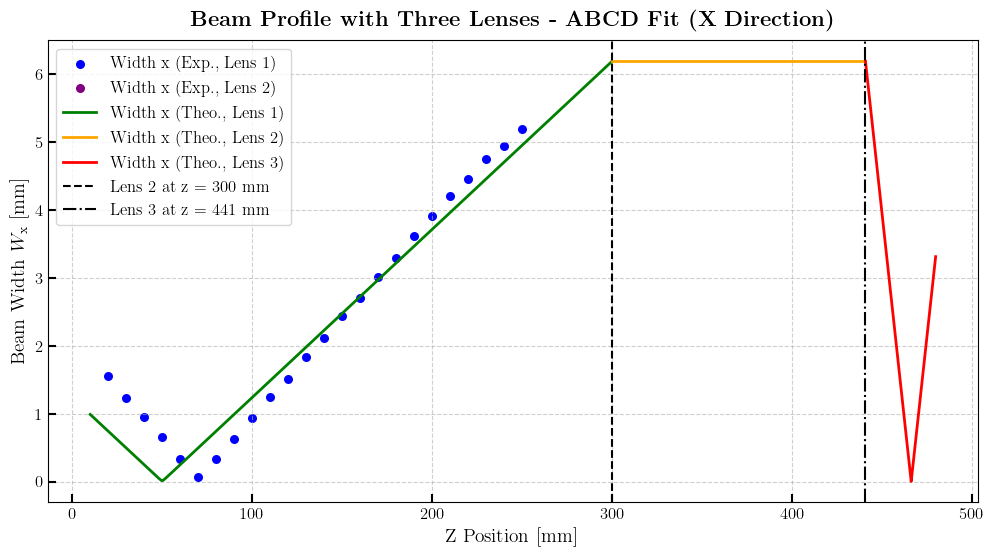

Saved: /Users/asca/Documents/Universitya/Master Thesis/code/Data/Focus Laser/20250403/2nd_config/fig/beam_profile_ABCD_y_three_lenses.png


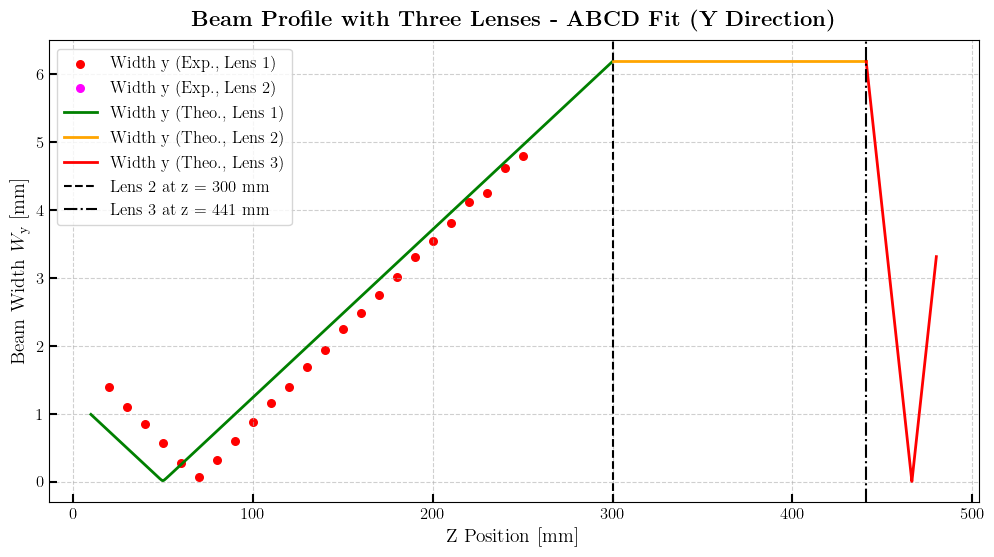

Min waist theo 1: 0.0139 Max waist theo: 6.1905
Min waist exp x: 0.0659 Min waist exp y: 0.0669
Min waist theo 2: 6.1904 Max waist theo: 6.1905
Min waist theo 3: 0.0023 Max waist theo: 6.1904


In [7]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250527/high_powerline"
data_path_2 = "/Users/asca/Documents/Universitya/Master Thesis/code/Data/Focus Laser/20250403/2nd_config/" 
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv")) 
                     if "before lens" not in os.path.basename(f).lower()])
file_list_2 = sorted(glob.glob(os.path.join(data_path_2, "*mm Beam Results.csv")))
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values = []
width_x = []
width_y = []

# Process first lens data (up to z = 150 mm)
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])  
    if z <= 300:  
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2]))  
            if "Width y" in line:
                width_y.append(float(line.split()[2]))  

# Process third lens data (z >= 441 mm) w/ error handling
for file in file_list_2:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0]) 
    z_values.append(z)

    with open(file, 'r') as f:
        lines = f.readlines()

    wx, wy = None, None
    for line in lines:
        if "Width x" in line:
            value = line.split()[2]
            try:
                wx = float(value)
            except ValueError:
                wx = None
        if "Width y" in line:
            value = line.split()[2]
            try:
                wy = float(value)
            except ValueError:
                wy = None
    
    if wx is not None and wy is not None:
        width_x.append(wx)
        width_y.append(wy)
    else:
        print(f"Warning: Skipping file {filename} due to invalid width values")
        z_values.pop()

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length1 = 50 
focal_length2 = 250  
focal_length3 = 25.4 
wavelength = 1.060e-3
z_lens2 = 300  
z_lens3 = 441 

# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Width x' or 'Width y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam width before the lens: Width x = {width_x_initial} mm, Width y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0

# Beam waist after the lens (at focal length)
W0 = width_x.min()  # Minimum width from data
z_waist = z_values[np.argmin(width_x)]  # Position of the waist
z_R = np.pi * W0**2 / wavelength  # Rayleigh range at the waist in mm

# Read W0_initial from file 
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0 (before the first lens)

# Apply the first lens transformation at z = 0 (from second code)
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1)  # Beam parameter just after the first lens

# Propagate to second lens position 
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)

# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
print(f"q3 (after second lens): {q3}")

# Propagate to third lens position 
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
print(f"q4 (before third lens at z = {z_lens3} mm): {q4}")

# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
print(f"q5 (after third lens): {q5}")

# Theoretical z-values
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 500)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 500)
z_theoretical3 = np.linspace(z_lens3, 480, 600)  # Propagate forward to z = 480 mm
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)

# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan 

# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan 

# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:  # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Width_x = {wx:.3f} mm, Width_y = {wy:.3f} mm")

# Plot Width x
plt.figure(figsize=(12, 6))
# Data before second lens
mask1 = z_values < 300
plt.scatter(z_values[mask1]+10, width_x[mask1], color='blue', label='Width x (Exp., Lens 1)', marker='o', s=30)
# Data after second lens
mask2 = z_values >= z_lens2
plt.scatter(z_values[mask2]-10, width_x[mask2], color='purple', label='Width x (Exp., Lens 2)', marker='o', s=30) #offset of -5mm in z_values to account for the actual position of the lens
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Width x (Theo., Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Width x (Theo., Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Width x (Theo., Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with Three Lenses - ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x_three_lenses.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_x}")
plt.show()

# Plot Width y
plt.figure(figsize=(12, 6))
# Data before second lens
plt.scatter(z_values[mask1]+10, width_y[mask1], color='red', label='Width y (Exp., Lens 1)', marker='o', s=30)
# Data after third lens
plt.scatter(z_values[mask2]-10, width_y[mask2], color='magenta', label='Width y (Exp., Lens 2)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Width y (Theo., Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Width y (Theo., Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Width y (Theo., Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Width $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile with Three Lenses - ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y_three_lenses.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_y}")
plt.show()

print(f"Min waist theo 1: {min(W_theoretical1):.4f}",f"Max waist theo: {max(W_theoretical1):.4f}")
print(f"Min waist exp x: {min(width_x):.4f}",f"Min waist exp y: {min(width_y):.4f}")
print(f"Min waist theo 2: {min(W_theoretical2):.4f}",f"Max waist theo: {max(W_theoretical2):.4f}")
print(f"Min waist theo 3: {min(W_theoretical3):.4f}",f"Max waist theo: {max(W_theoretical3):.4f}")